In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, precision_recall_curve, roc_curve

import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [2]:
PROJECT_ROOT = Path("..")
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "model_data_2016Q1.parquet"

df = pd.read_parquet(DATA_PATH)

print("Shape:", df.shape)
print("Default rate:", df["default_24m"].mean())
df.head()


Shape: (338473, 11)
Default rate: 0.007826325881237203


,loan_id,months_observed,default_24m,report_period,orig_interest_rate,orig_upb,orig_loan_term,property_type,loan_purpose,property_state,loan_type
0,100000512540,24,0,2016-02-01,3.750,65000.0,360,SF,P,GA,FRM
1,100000549022,24,0,2016-03-01,4.000,153000.0,360,SF,P,KS,FRM
2,100003006281,24,0,2016-03-01,3.625,114000.0,360,SF,P,IL,FRM
3,100003784303,24,0,2016-03-01,3.875,150000.0,360,PU,P,IN,FRM
4,100004643080,24,0,2016-01-01,4.250,40000.0,360,PU,P,TX,FRM


In [3]:
y = df["default_24m"].astype(int)

X = df.drop(columns=["default_24m"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Default rate:", y_train.mean())
print("Test shape:", X_test.shape, "Default rate:", y_test.mean())


Train shape: (253854, 10) Default rate: 0.007827333821803084
Test shape: (84619, 10) Default rate: 0.00782330209527411


In [6]:
numeric_features = ["orig_interest_rate", "orig_upb", "orig_loan_term"]
categorical_features = ["property_type", "loan_purpose", "property_state", "loan_type"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

clf = LogisticRegression(
    max_iter=5000,   # increased
    solver="lbfgs",
    class_weight="balanced"
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", clf)
])


In [7]:
model.fit(X_train, y_train)

proba = model.predict_proba(X_test)[:, 1]

roc = roc_auc_score(y_test, proba)
pr = average_precision_score(y_test, proba)

print("ROC AUC:", roc)
print("PR AUC:", pr)


ROC AUC: 0.818744495051002
PR AUC: 0.053584510621372594


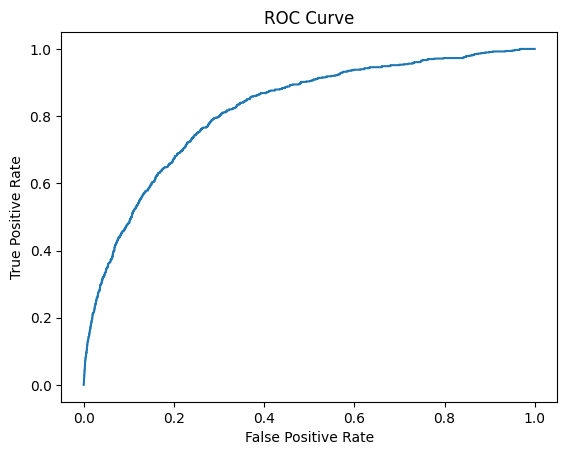

In [8]:
fpr, tpr, _ = roc_curve(y_test, proba)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


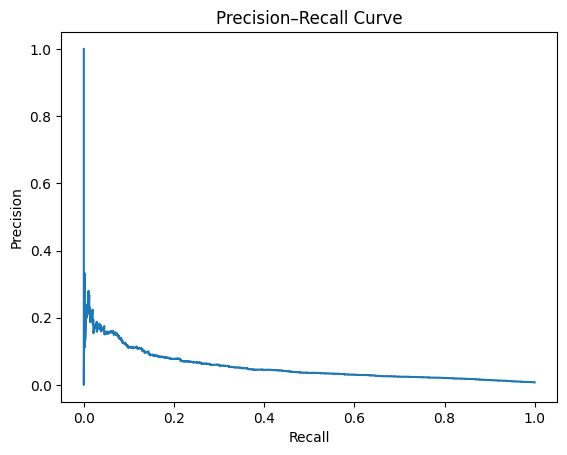

In [9]:
precision, recall, thresholds = precision_recall_curve(y_test, proba)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()


In [10]:
target_recall = 0.50  # catch half of defaults as a baseline

idx = np.argmin(np.abs(recall[:-1] - target_recall))
chosen_threshold = thresholds[idx]

print("Chosen threshold:", chosen_threshold)
print("Precision at target recall:", precision[idx])
print("Recall:", recall[idx])

y_pred = (proba >= chosen_threshold).astype(int)
print(classification_report(y_test, y_pred, digits=4))


Chosen threshold: 0.6923999002827813
Precision at target recall: 0.03580700995240156
Recall: 0.5
              precision    recall  f1-score   support

           0     0.9956    0.8938    0.9420     83957
           1     0.0358    0.5000    0.0668       662

    accuracy                         0.8908     84619
   macro avg     0.5157    0.6969    0.5044     84619
weighted avg     0.9881    0.8908    0.9351     84619

